# Summary source prediction: Model selection

Sébastien Meyer

This notebook gathers the main preprocessing functions for data preparation which can be found in our package. Then, you can try out some models or feature selection. Enjoy!

In [25]:
import warnings

import numpy as np
import pandas as pd

import nltk

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, cv

from mlxtend.classifier import StackingCVClassifier
from mlxtend.feature_selection import SequentialFeatureSelector

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


from src.preprocessing.reader import check_features_names

from src.preprocessing.features.gltr import create_gltr_feat
from src.preprocessing.features.polynomial import create_poly_feat
from src.preprocessing.features.manual_regex import create_regex_feat
from src.preprocessing.features.pos_tagging import ALL_NLTK_TAGS, create_tagging_feat
from src.preprocessing.features.tfidf import create_idf_feat
from src.preprocessing.reduction.droping import drop_corr_feat, drop_list_feat
from src.preprocessing.reduction.pca import perform_pca

In [2]:
# Seed to use everywhere for reproducibility
seed = 8005

# Package options and global variables
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

np.random.seed(seed)

nltk.download("averaged_perceptron_tagger")
nltk.download("stopwords")

# Display options
pd.set_option("display.max_columns", None)

font = {"size": 18}
mpl.rc("font", **font)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sebastien/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sebastien/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def plot_rep(df, feature, save=False):
    
    plt.figure(figsize=(10, 8))

    color = iter(plt.cm.brg(np.linspace(0, 1, 2)))

    sns.kdeplot(df.loc[df["label"] == 0, feature], label="label = 0", color=next(color))
    sns.kdeplot(df.loc[df["label"] == 1, feature], label="label = 1", color=next(color))

    plt.legend(loc="best")
    
    if save:
        plt.tight_layout()
        plt.savefig(f"report/figures/{feature}_repart.png", facecolor="white")
    else:
        plt.title(f"Repartition of {feature} among label")
    
    plt.show()

## Feature engineering

In [4]:
# Read files
train_df = pd.read_json("data/train_set.json")
test_df = pd.read_json("data/test_set.json")
documents = pd.read_json("data/documents.json")

# Extract target
label_var = ["label"]
y_train = train_df[label_var]
train_df.drop(columns=label_var, inplace=True)

### Regex features

List of all regex features to compute. The name of a regex feature should be of the form "A_B". A is the name of the regex expression, for example "upper_word". B is the type of feature we want, it can be "count" for the number of instances, "avg" for the average length of instances, "overlap" for the number of instances both found in the summary and the original document or "ratio" for the ratio between the number of instances found in the summary and the number of instances found in the document. Example: --regex-feat char_count group_overlap.

In [5]:
regex_feat = [
    "char_count", "char_ratio",
    "word_count", "word_overlap", "word_ratio",
    "sent_avg",
    "upper_word_ratio",
    "group_overlap",
    "is_last_ponct_count",
    "space_before_ponct_count",
    "word_3_count"
]

create_regex_feat(train_df, test_df=test_df, regex_feat=regex_feat)


Computing regex features...
Number of regex features: 11.


### Tf-idf features

List of all tf-idf features names to compute. The name of an idf feature is expected to be of the form "A_B". A is a sequence of characters for the composition performed in `src.preprocessing.features.tfidf.idf_composition()`. B is the type of feature we want, it can be "count" for the term frequencies, "lda" for the latent dirichlet allocation, "idf" for idf features after a PCA transformation that keeps **svd_components** components from the initial counter features or "cos" for the cosine similarity between the summary and the original document.

In [6]:
idf_feat = [
    "n_count", "n_idf", "n_lda"
]

create_idf_feat(seed, train_df, test_df=test_df, idf_feat=idf_feat, more_docs=documents, svd_components=1)


Computing idf features...
Number of idf features: 5.


### Tagging features

List of all tagging features to compute. The name of a tagging feature must be of the form "A_B". A is a tag from all available tags in `nltk` or "tags". B is the type of feature we want, it can be "count" for the number of instances, "avg" for the average length of instances, "overlap" for the number of instances both found in the summary and the original document, "ratio" for the ratio between the number of instances found in the summary and the number of instances found in the document or "C_D" where C and D are parameters for idf features.

In [7]:
tag_feat = [
    "DT_count", "DT_overlap",
    "MD_count",
    "NN_overlap",
    "RB_count",
    "$_overlap",
    ":_overlap"
]

create_tagging_feat(seed, train_df, test_df=test_df, tag_feat=tag_feat, more_docs=documents, svd_components=1)


Computing tagging features...
Number of tagging features: 7.


### GLTR features

List of all GLTR features to compute. The name of a GLTR feature should be of the form "A_B". A is the name of a topk value computed by GLTR, it can be "count" or "frac". B is the number of bins to compute the feature.

In [8]:
gltr_feat = [
    "count_4", "frac_10"
]

train_df, test_df = create_gltr_feat(train_df, test_df=test_df, gltr_feat=gltr_feat)


Computing GLTR features...


Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

Loaded GPT-2 model!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3200/3200 [02:01<00:00, 26.37it/s]

Number of GLTR features: 14.


### Polynomial features

- List of specific polynomial features. A fixed polynomial feature must be of the form "A B C". A, B and C can be features or powers of features, and their product will be computed. Example: --fixed-poly-feat "char_count^2 group_overlap".
- List of polynomial features to compute of which interaction terms will be computed.
- Define the degree until which products and powers of features are computed. If 1 or less, there will be no polynomial features. 

In [9]:
fixed_poly_feat = []
poly_feat = []
poly_degree = 2

create_poly_feat(
    train_df, test_df=test_df, fixed_poly_feat=fixed_poly_feat, 
    poly_feat=poly_feat, poly_degree=poly_degree
)

### Drop excluded features

List of features names to drop after computation. Example: --excl-feat "char_count^2 group_overlap".

In [10]:
excl_feat = [
    "document", "summary",
    "n_lda_2", "n_lda_3"
] + [
    f"topk_frac_{i}" for i in range(1, 10)
]

drop_list_feat(train_df, test_df=test_df, excl_feat=excl_feat)


Dropping specific features...
Number of features after dropping excluded ones: 27


### Drop correlated features

Correlation threshold to select features. 

In [11]:
corr_threshold = 1.

drop_corr_feat(train_df, test_df=test_df, corr_threshold=corr_threshold)

### Rescale the data

In [12]:
# Rescale the data
sc = StandardScaler()

train_df[train_df.columns] = sc.fit_transform(train_df[train_df.columns])
test_df[test_df.columns] = sc.transform(test_df[test_df.columns])

### PCA

Variance ratio parameter for the Principal Component Analysis.

In [13]:
pca_ratio = 1.

train_df, test_df = perform_pca(seed, train_df, test_df=test_df, pca_ratio=pca_ratio)

### Final df

In [14]:
# Print some information
print(f"Final training shape: {train_df.shape}")
print(f"Features names: {list(train_df.columns)}")

# Re-create the label variable
train_df = train_df.merge(y_train, left_index=True, right_index=True, how="left")

# Train test split
X = train_df.drop(columns=label_var).to_numpy()
y = train_df[label_var].to_numpy().flatten()

Final training shape: (8000, 27)
Features names: ['char_count', 'char_ratio', 'word_count', 'word_overlap', 'word_ratio', 'sent_avg', 'upper_word_ratio', 'group_overlap', 'is_last_ponct_count', 'space_before_ponct_count', 'word_3_count', 'n_count_PCA_1', 'n_idf_PCA_1', 'n_lda_0', 'n_lda_1', 'DT_count', 'DT_overlap', 'MD_count', 'NN_overlap', 'RB_count', '$_overlap', ':_overlap', 'topk_count_0', 'topk_count_1', 'topk_count_2', 'topk_count_3', 'topk_frac_0']


## Show some distribution of labels wrt a feature

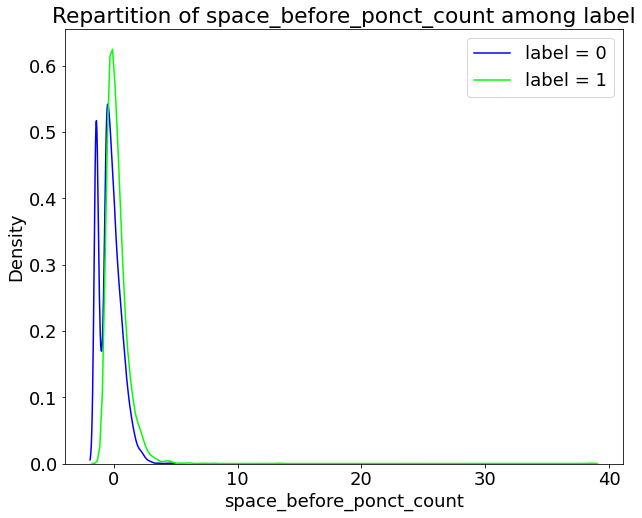

In [15]:
feature = "space_before_ponct_count"

if feature in train_df.columns:
    plot_rep(train_df, feature, save=False)

## Try it!

In [16]:
logreg = LogisticRegression(solver="newton-cg")

print("Cross-val accuracy:", np.around(np.mean(cross_val_score(logreg, X, y, scoring="accuracy", cv=5, n_jobs=-1)), 4))

Cross-val accuracy: 0.8434


In [17]:
rfc = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1, verbose=0)

print("Cross-val accuracy:", np.around(np.mean(cross_val_score(rfc, X, y, scoring="accuracy", cv=5, n_jobs=-1)), 4))

Cross-val accuracy: 0.9074


In [18]:
etc = ExtraTreesClassifier(n_estimators=100, random_state=seed, n_jobs=-1)

print("Cross-val accuracy:", np.around(np.mean(cross_val_score(etc, X, y, scoring="accuracy", cv=5, n_jobs=-1)), 4))

Cross-val accuracy: 0.897


In [19]:
lgbm = LGBMClassifier(random_state=seed)

print("Cross-val accuracy:", np.around(np.mean(cross_val_score(lgbm, X, y, scoring="accuracy", cv=5, n_jobs=-1)), 4))

Cross-val accuracy: 0.9174


In [20]:
skf = StratifiedKFold()
scores = []

for train_index, val_index in skf.split(X, y):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    xgb = XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric="logloss")
    xgb.fit(X_train, y_train)
    
    scores.append(accuracy_score(y_val, xgb.predict(X_val)))    
    
print("Cross-val accuracy:", np.around(np.mean(scores), 4))

Cross-val accuracy: 0.9156


In [24]:
cat = CatBoostClassifier(n_estimators=5000, random_state=seed, verbose=250, allow_writing_files=False)

print("Cross-val accuracy:", np.around(np.mean(cross_val_score(cat, X, y, scoring="accuracy", cv=5, n_jobs=1)), 4))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.005203
0:	learn: 0.6862881	total: 2.3ms	remaining: 11.5s
250:	learn: 0.3108395	total: 553ms	remaining: 10.5s
500:	learn: 0.2595875	total: 1.11s	remaining: 9.94s
750:	learn: 0.2322414	total: 1.62s	remaining: 9.16s
1000:	learn: 0.2142721	total: 2.14s	remaining: 8.54s
1250:	learn: 0.2001637	total: 2.63s	remaining: 7.87s
1500:	learn: 0.1881426	total: 3.12s	remaining: 7.27s
1750:	learn: 0.1769910	total: 3.6s	remaining: 6.68s
2000:	learn: 0.1664409	total: 4.08s	remaining: 6.12s
2250:	learn: 0.1570737	total: 4.56s	remaining: 5.57s
2500:	learn: 0.1483805	total: 5.04s	remaining: 5.04s
2750:	learn: 0.1407140	total: 5.53s	remaining: 4.52s
3000:	learn: 0.1339696	total: 6.02s	remaining: 4.01s
3250:	learn: 0.1276292	total: 6.53s	remaining: 3.51s
3500:	learn: 0.1218820	total: 7.04s	remaining: 3.01s
3750:	learn: 0.1164719	total: 7.54s	remaining: 2.51s
4000:	learn: 0.1114868	total: 8.05s	remaining: 2.01s
4250:	learn: 0.1070862	total: 8.56s	remaining: 1.51s
4500:	learn: 0.1027664	

In [27]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

cat = CatBoostClassifier(n_estimators=5000, random_state=seed, verbose=250, allow_writing_files=False,
                         eval_metric="Accuracy")

cat.fit(x_train, y_train, eval_set=[(x_val, y_val)])

Learning rate set to 0.024888
0:	learn: 0.8528125	test: 0.8593750	best: 0.8593750 (0)	total: 2.12ms	remaining: 10.6s
250:	learn: 0.9254687	test: 0.9112500	best: 0.9125000 (241)	total: 536ms	remaining: 10.1s
500:	learn: 0.9528125	test: 0.9243750	best: 0.9250000 (461)	total: 1.09s	remaining: 9.8s
750:	learn: 0.9671875	test: 0.9218750	best: 0.9268750 (613)	total: 1.66s	remaining: 9.41s
1000:	learn: 0.9778125	test: 0.9231250	best: 0.9268750 (613)	total: 2.26s	remaining: 9.02s
1250:	learn: 0.9871875	test: 0.9225000	best: 0.9268750 (613)	total: 2.81s	remaining: 8.44s
1500:	learn: 0.9926563	test: 0.9218750	best: 0.9268750 (613)	total: 3.38s	remaining: 7.87s
1750:	learn: 0.9959375	test: 0.9218750	best: 0.9268750 (613)	total: 3.92s	remaining: 7.28s
2000:	learn: 0.9981250	test: 0.9218750	best: 0.9268750 (613)	total: 4.47s	remaining: 6.7s
2250:	learn: 0.9992188	test: 0.9206250	best: 0.9268750 (613)	total: 5.01s	remaining: 6.12s
2500:	learn: 0.9993750	test: 0.9193750	best: 0.9268750 (613)	total: 5

In [28]:
rfc = RandomForestClassifier(
    max_samples=None, bootstrap=True, random_state=seed, n_jobs=1, n_estimators=69,
    criterion="gini", max_depth=None, min_samples_split=7, min_samples_leaf=2,
    max_features=0.4, ccp_alpha=6.32e-6
)
lgbm = LGBMClassifier(
    objective="binary", verbose=-1, random_state=seed, n_jobs=1, n_estimators=122,
    num_leaves=20, min_split_gain=2.42e-7, min_child_weight=5.45e-7, min_child_samples=2,
    subsample=0.910, subsample_freq=4, reg_alpha=6.92e-6, reg_lambda=8.82e-4
)
xgb = XGBClassifier(
    eval_metric="logloss", use_label_encoder=False, random_state=seed, n_estimators=178,
    subsample=0.649, colsample_bytree=0.83, colsample_bylevel=0.75, colsample_bynode=0.67,
    max_delta_step=0.14, reg_alpha=3.01e-5, reg_lambda=3.02e-7, grow_policy="lossguide"
)
cat = CatBoostClassifier(
    verbose=False, allow_writing_files=False, random_state=seed, n_estimators=222,
    learning_rate=0.03, grow_policy="Depthwise", bootstrap_type="MVS",
    leaf_estimation_iterations=10, leaf_estimation_backtracking="AnyImprovement",
    od_type="IncToDec", l2_leaf_reg=1.61e-4, min_data_in_leaf=5, subsample=0.62
)

meta_cls = LogisticRegression()

skf = StratifiedKFold()
scores = []

for train_index, val_index in skf.split(X, y):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    stacking = StackingCVClassifier(
        [rfc, xgb, lgbm, cat], meta_cls, use_probas=False, cv=5, shuffle=True, random_state=seed,
        verbose=1, n_jobs=1
    )
    stacking.fit(X_train, y_train)
    
    scores.append(accuracy_score(y_val, stacking.predict(X_val)))    
    print(scores[-1])
    
print("Cross-val accuracy:", np.around(np.mean(scores), 4))

Fitting 4 classifiers...
Fitting classifier1: randomforestclassifier (1/4)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/4)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: lgbmclassifier (3/4)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: catboostclassifier (4/4)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.0s finished


0.91375
Fitting 4 classifiers...
Fitting classifier1: randomforestclassifier (1/4)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/4)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: lgbmclassifier (3/4)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: catboostclassifier (4/4)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.2s finished


0.913125
Fitting 4 classifiers...
Fitting classifier1: randomforestclassifier (1/4)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/4)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: lgbmclassifier (3/4)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: catboostclassifier (4/4)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.3s finished


0.920625
Fitting 4 classifiers...
Fitting classifier1: randomforestclassifier (1/4)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/4)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: lgbmclassifier (3/4)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: catboostclassifier (4/4)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.2s finished


0.908125
Fitting 4 classifiers...
Fitting classifier1: randomforestclassifier (1/4)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier2: xgbclassifier (2/4)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier3: lgbmclassifier (3/4)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting classifier4: catboostclassifier (4/4)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.4s finished


0.9225
Cross-val accuracy: 0.9156


## Some feature selection using SFS

In [29]:
rfc = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=1)

sfs = SequentialFeatureSelector(
    rfc, k_features=5, forward=True, floating=True, verbose=2, scoring="accuracy", cv=5, n_jobs=-1
)

sfs.fit(X, y, custom_feature_names=test_df.columns)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   13.9s finished

[2022-04-17 12:55:33] Features: 1/5 -- score: 0.7095[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:   16.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s finished

[2022-04-17 12:55:52] Features: 2/5 -- score: 0.760375[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   14.5s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   15.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.1s finished

[2022-04-17 12:56:09] Features: 3/5 -- score: 0.81325[Parallel(n_jobs=-1)]:

SequentialFeatureSelector(estimator=RandomForestClassifier(n_jobs=1,
                                                           random_state=8005),
                          floating=True, k_features=5, n_jobs=-1,
                          scoring='accuracy', verbose=2)

In [30]:
sfs.subsets_

{1: {'feature_idx': (5,),
  'cv_scores': array([0.72375 , 0.696875, 0.698125, 0.715   , 0.71375 ]),
  'avg_score': 0.7095,
  'feature_names': ('sent_avg',)},
 2: {'feature_idx': (0, 5),
  'cv_scores': array([0.756875, 0.75125 , 0.761875, 0.751875, 0.78    ]),
  'avg_score': 0.760375,
  'feature_names': ('char_count', 'sent_avg')},
 3: {'feature_idx': (0, 3, 5),
  'cv_scores': array([0.80875 , 0.814375, 0.809375, 0.813125, 0.820625]),
  'avg_score': 0.81325,
  'feature_names': ('char_count', 'word_overlap', 'sent_avg')},
 4: {'feature_idx': (0, 3, 5, 9),
  'cv_scores': array([0.865625, 0.87125 , 0.85375 , 0.86625 , 0.875625]),
  'avg_score': 0.8665,
  'feature_names': ('char_count',
   'word_overlap',
   'sent_avg',
   'space_before_ponct_count')},
 5: {'feature_idx': (0, 3, 5, 9, 26),
  'cv_scores': array([0.881875, 0.885625, 0.875625, 0.88    , 0.8875  ]),
  'avg_score': 0.8821249999999999,
  'feature_names': ('char_count',
   'word_overlap',
   'sent_avg',
   'space_before_ponct_coun

In [31]:
lgbm = LGBMClassifier(random_state=seed)

sfs2 = SequentialFeatureSelector(
    lgbm, k_features=5, forward=True, floating=True, verbose=2, scoring="accuracy", cv=5, n_jobs=-1
)

sfs2.fit(X, y, custom_feature_names=test_df.columns)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    2.1s finished

[2022-04-17 12:56:59] Features: 1/5 -- score: 0.69875[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished

[2022-04-17 12:57:02] Features: 2/5 -- score: 0.7769999999999999[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.3s finished

[2022-04-17 12:57:05] Features: 3/5 -- score: 0.834875[Parallel(

SequentialFeatureSelector(estimator=LGBMClassifier(random_state=8005),
                          floating=True, k_features=5, n_jobs=-1,
                          scoring='accuracy', verbose=2)

In [32]:
sfs2.subsets_

{1: {'feature_idx': (5,),
  'cv_scores': array([0.705   , 0.70125 , 0.679375, 0.696875, 0.71125 ]),
  'avg_score': 0.69875,
  'feature_names': ('sent_avg',)},
 2: {'feature_idx': (0, 5),
  'cv_scores': array([0.781875, 0.774375, 0.765   , 0.76625 , 0.7975  ]),
  'avg_score': 0.7769999999999999,
  'feature_names': ('char_count', 'sent_avg')},
 3: {'feature_idx': (0, 3, 5),
  'cv_scores': array([0.835625, 0.828125, 0.83125 , 0.83625 , 0.843125]),
  'avg_score': 0.834875,
  'feature_names': ('char_count', 'word_overlap', 'sent_avg')},
 4: {'feature_idx': (0, 3, 5, 9),
  'cv_scores': array([0.8775  , 0.881875, 0.878125, 0.87625 , 0.879375]),
  'avg_score': 0.8786249999999999,
  'feature_names': ('char_count',
   'word_overlap',
   'sent_avg',
   'space_before_ponct_count')},
 5: {'feature_idx': (0, 3, 5, 8, 9),
  'cv_scores': array([0.885   , 0.893125, 0.893125, 0.8875  , 0.900625]),
  'avg_score': 0.891875,
  'feature_names': ('char_count',
   'word_overlap',
   'sent_avg',
   'is_last_po